# Convolutional Neural Network (CNN)

`
Convolutional Neural Networks (ConvNets or CNNs) are a category of Neural Networks that have proven very effective in areas such as image recognition and classification. ConvNets have been successful in identifying faces, objects and traffic signs apart from powering vision in robots and self driving cars.
`

More details in the link: https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/

## Introduction

In this lab, we will build a Convolutional Neural Network to automatically detecting P and S phases in the seismic waveforms. This lab is modified from the paper entitled "Generalized Seismic Phase Detection with Deep Learning" by Zachary E. Ross et al., 2019. The link of this paper is: https://arxiv.org/abs/1805.01075

The training dataset are provided in the Waveform.npy and Label.npy. The waveforms (X) are composed by 3 channels (N,E,Z) with the window length of 4 seconds. The sampling rate is 100 Hz. Therefore, for each training sample, it has 400*3 data points. The Labels (Y) distinguish 3 classes (P,S, and Noise windows) with 3 numbers (0,1,2). In order to perform multiple classification by CNN, we need to do one-hot encoding for the labels. The link of why we need one-hot encoding is attached: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/ . By using one-hot encoding we change the labels 0,1,and 2 into [1,0,0],[0,1,0],and[0,0,1] 

We then split the training dataset into two parts: one for training, one for validation. We use the validation dataset to select best model. To measure the performance of best trained model, we will then plot [confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/#:~:text=A%20confusion%20matrix%20is%20a,related%20terminology%20can%20be%20confusing.), [precision-recall curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) and [ROC curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

The last and most important part is to test our CNN model in the continous waveforms, which is provided in Continous_Waveforms.npz. We use a sliding window to perform CNN continously. The CNN model would output the probablity which class the sliding window belongs to. 

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from obspy.signal.trigger import trigger_onset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D,Flatten,Dense,Dropout,BatchNormalization
from keras.utils import np_utils
from keras.optimizers import Adam

## Read Data 

Load waveform (X) and label (Y) dataset from Southern California Earthquake Data Center http://scedc.caltech.edu/research-tools/deeplearning.html. The dataset used in this labe includes 10000 samples (1% of total dataset). The following code would plot 3 examples of P/S wave and Noise windows. The window length are all 4 seconds with sampling rate of 100 Hz. The P and S wave arrivals occurs at the center of the windows. 

In order to perform multiple classification by CNN, we need to do one-hot encoding for the labels [[link]](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). By using one-hot encoding we change the labels 0,1,and 2 into [1,0,0],[0,1,0],and[0,0,1] respectively. We use [1,0,0],[0,1,0],and[0,0,1] to represent P phase, noise, and S pahse respectively.


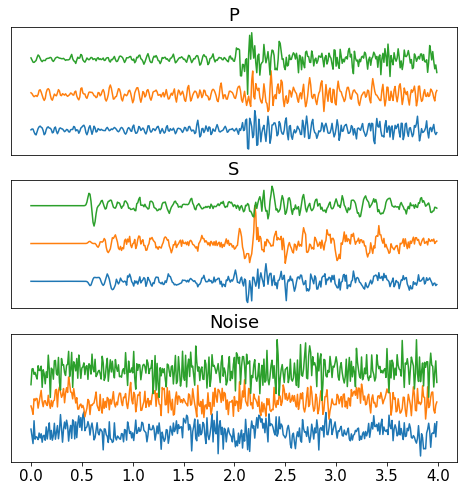

In [2]:
X=np.load('Waveform.npy')
Y=np.load('Label.npy')
labels=['P','S','Noise']

# Plot examples of 3 classes
matplotlib.rc('font', **{'size'   : 15})

order=[0,2,1]
plt.figure(figsize=(8,8))
for k in range(3):
    plt.subplot(3,1,k+1)
    for i in range(3):
        plt.plot(np.arange(400)*0.01,X[order[k],:,i]+i)
    plt.title(labels[k])
    plt.yticks([])
    if k<2:
        plt.xticks([])
plt.show()


# convert integers to dummy variables (one hot encoding)
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(Y)
en_Y = np_utils.to_categorical(encoded_Y)

# split dataset into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, en_Y, test_size=0.33, random_state=42)


## Build Model

Training a convolutional nerual network is similar to training a nerual network. You can find the definition of loss function, optimizer, activation functions, epoch and batch size in the lab of nerual network. 

The largest difference between CNN and NN is that CNN use layers called Conv1D or Conv2D. In our lab, waveforms are time series not a 2D images. So we use the [Conv1D](https://keras.io/api/layers/convolution_layers/convolution1d/). The first argument for Conv1D is the number of filters. It means the dimensionality of the output space (i.e. the number of output filters in the convolution). It must be a integer. The second argument is kernel size. It specifies the length of the 1D convolution window. Another important argument is strides, specifying the stride length of the convolution. It means the downsampling rate, if you set stride equals 2, the output time series would downsample by 2. It has similar effect as [pooling layers](https://keras.io/api/layers/pooling_layers/max_pooling1d/). The first layer is very special, you need to define the input shape (input_shape). In our case the shape of input is 400*3. The window length of a recording of waveform is 4 seconds and the sampling rate is 100 Hz. So we had 400 points for a waveform recording. The number 3 means the number of channels (N,E,Z).

We usually use relu function for the activation functions in the Conv1D and Dense layers, however, for the last layer, we should use softmax. The softmax function takes the output vector, and scales all values such that they sum up to 1. In this way, we get a vector of probabilities. The first entry in the output corresponds to the probability that the input image is a 0, the second entry that the input is 1, etc.:

$$
P = \left[\begin{matrix} p(0) \\ p(1) \\ p(2) \\ ... \\ p(9) \end{matrix} \right] \quad , \quad \sum_{i=0}^9 P_i = 1
$$

We now have to choose a loss function. For multi-class classification tasks, _categorical cross-entropy_ is usually a good choice. This loss function is defined as follows:

$$
\mathcal{L} = - \sum_{c=0}^N y_c \log \left( p_c \right)
$$

where $y_c$ is the label of class $c$, and $p$ is the predicted probability. Note that $y_c$ is either 0 or 1, and that $0 < p_c < 1$. With our chosen loss function, we are ready for the final assembly of the model.

In addition, we add Dropout. You can learn more about it if you are insterested. [Dropout](https://towardsdatascience.com/machine-learning-part-20-dropout-keras-layers-explained-8c9f6dc4c9ab) is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.

We build the model with the following code:
```
model = Sequential()
model.add(Conv1D(16, 3, activation='relu',strides=2,input_shape=(n_in,3)))
model.add(Conv1D(32, 3, strides=2,activation='relu'))
model.add(Conv1D(64, 3, strides=2,activation='relu'))
model.add(Conv1D(128, 3, strides=2,activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
```
The model structure is shown below:

![image](./Fig/phase_model.png)

In [4]:
# 3 classes
n_in=400
model = Sequential()
model.add(Conv1D(16, 3, activation='relu',strides=2,input_shape=(n_in,3)))
model.add(Conv1D(32, 3, strides=2,activation='relu'))
model.add(Conv1D(64, 3, strides=2,activation='relu'))
model.add(Conv1D(128, 3, strides=2,activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()

adam=Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Early stop
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('CNNclassifier.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
history=model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val),
                callbacks=[es,mc], verbose=0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 199, 16)           160       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 99, 32)            1568      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 49, 64)            6208      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 24, 128)           24704     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               393344    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 199, 16)           160       
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 99, 32)            1568      
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 49, 32)            3104      
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 24, 64)            6208      
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 11, 64)            12352     
_________________________________________________________________
flatten_11 (Flatten)         (None, 704)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)             

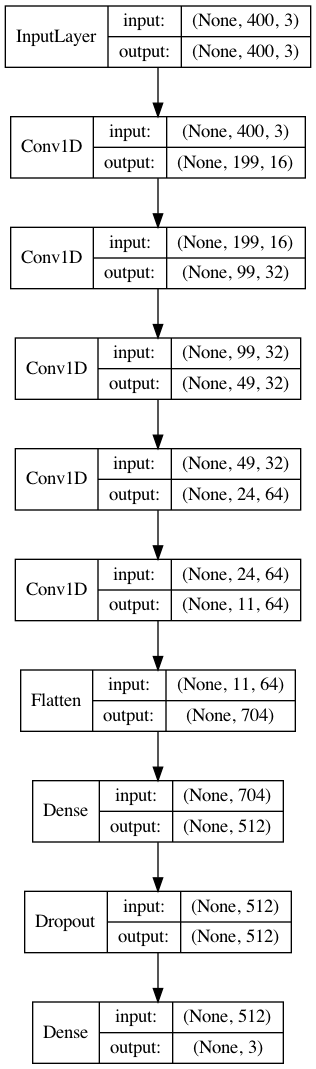

In [26]:
# Q1
# Filter size in the all Conv1D layers are 3.
# Strides are all 2
model = Sequential()
model.add(Conv1D(16, 3, activation='relu',strides=2,input_shape=(n_in,3)))
model.add(Conv1D(32, 3, strides=2,activation='relu'))
model.add(Conv1D(32, 3, strides=2,activation='relu'))
model.add(Conv1D(64, 3, strides=2,activation='relu'))
model.add(Conv1D(64, 3, strides=2,activation='relu'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()
plot_model(model, to_file='Fig/Q_1.png', show_shapes=True, show_layer_names=False)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 197, 16)           352       
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 97, 64)            5184      
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 48, 128)           24704     
_________________________________________________________________
flatten_10 (Flatten)         (None, 6144)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               3146240   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)               

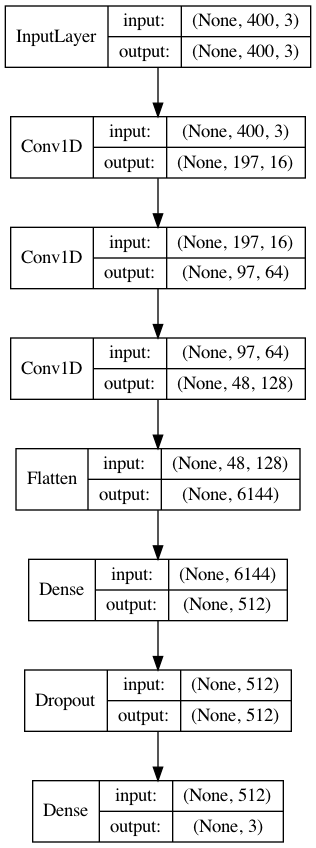

In [25]:
# Q2
# Filter size in the first Conv1D is 7
# in the second Conv1D is 5
# in the third Conv1D is 3
# Strides are all 2.
n_in=400
model = Sequential()
model.add(Conv1D(16, 7, activation='relu',strides=2,input_shape=(n_in,3)))
model.add(Conv1D(64, 5, strides=2,activation='relu'))
model.add(Conv1D(128, 3, strides=2,activation='relu'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()
plot_model(model, to_file='Fig/Q_2.png', show_shapes=True, show_layer_names=False)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 133, 16)           160       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 44, 32)            1568      
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 14, 32)            3104      
_________________________________________________________________
flatten_9 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               114944    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                

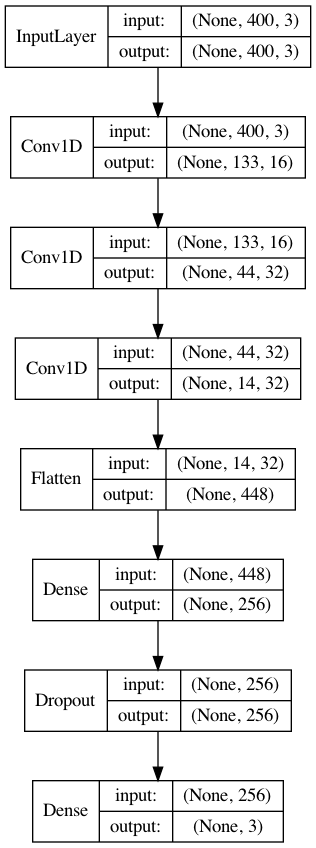

In [24]:
# Q3
# Filter size in the all Conv1D layers are 3.
# Strides are all 3
model = Sequential()
model.add(Conv1D(16, 3, activation='relu',strides=3,input_shape=(n_in,3)))
model.add(Conv1D(32, 3, strides=3,activation='relu'))
model.add(Conv1D(32, 3, strides=3,activation='relu'))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()
plot_model(model, to_file='Fig/Q_3.png', show_shapes=True, show_layer_names=False)

## Training History

We have recorded the history of training in a variable named history. We wll then visualize the history of training/validation loss. In addition to loss, we can present the metrics change with training epoch. In the following plots, you would expect the training loss would be smaller than validation loss after certain epoch. It means the model start to overfitting after that epoch and we should stop training then.


accuracy: 94.58%


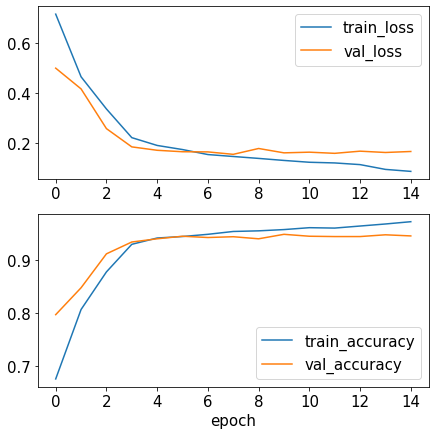

In [8]:
# plot metrics
plt.figure(figsize=(7,7))
plt.subplot(211)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss','val_loss'])
plt.subplot(212)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy','val_accuracy'])
plt.xlabel('epoch')
scores = model.evaluate(X_val, y_val, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## [Plotting Confusion Matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/#:~:text=A%20confusion%20matrix%20is%20a,related%20terminology%20can%20be%20confusing.)

In this section, we would plot the confusion matrix. You could learn more about it through the link

[[1025   50   49]
 [  24 1034   27]
 [  16   13 1062]]


Text(0.5, 31.943301820015094, 'Predicted label')

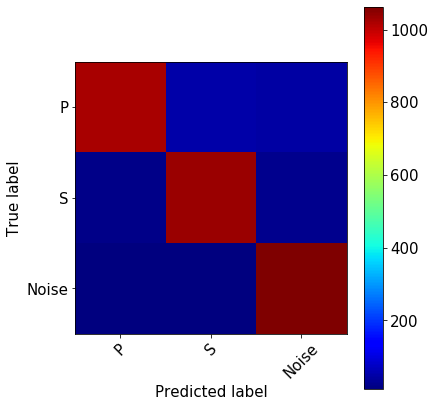

In [9]:
y_pred = model.predict(X_val)
y_val_nonhot=np.round(y_val.argmax(axis=1))
y_pred_nonhot=np.round(y_pred.argmax(axis=1))
cm = confusion_matrix(y_val_nonhot, y_pred_nonhot)
print(cm)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap='jet')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylim([2.5,-0.5])
plt.xlim([-0.5,2.5])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

## [Plotting Precision-Recall Curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

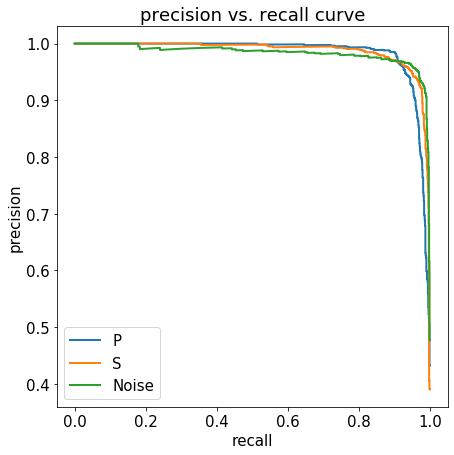

In [10]:
# precision recall curve

plt.figure(figsize=(7,7))
precision = dict()
recall = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_val[:, i],y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{}'.format(labels[i]))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

## [Plotting ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)


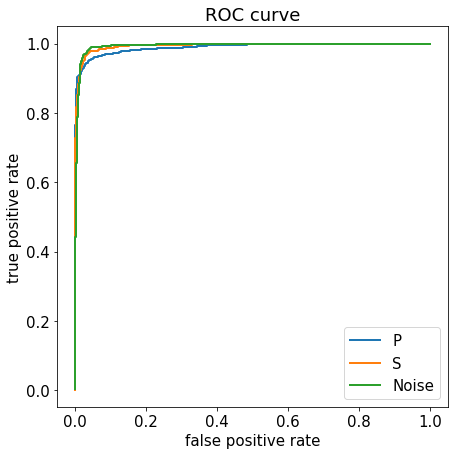

In [11]:
# roc curve
plt.figure(figsize=(7,7))

fpr = dict()
tpr = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred[:, i])
    
    plt.plot(fpr[i], tpr[i], lw=2, label='{}'.format(labels[i]))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

## Test on Continous Waveforms

Load Continous waveform dataset with P/S phase arrival times. This dataset are used to testing the accuracy of CNN model in picking P/S phase arrival times. By utilizing silding windows, we could output the probabilty of each windows (whether it belongs P/S/noise). Therefore, we could get the predict probability as a function of time. As we known that the human labeled arrival time 
also have uncertainties, we use a normal distribution to represent the uncertainties. Now, we change the label of a sigle number into the probability as a function of time.

Here we use [cross-entropy function](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#:~:text=Cross%2Dentropy%20loss%2C%20or%20log,diverges%20from%20the%20actual%20label.) to measure the difference between predict and human labeled probablity distributions. The smaller the enetropy, the closer two distributions are. Therefore, the performance of the model is better if entropy is smaller.


In [12]:
data = np.load('Continous_Waveforms.npz')
quake = data['quake']
p_arrival=data['p_arrival']
s_arrival=data['s_arrival']

In [13]:
#####################
# Hyperparameters
min_proba = 0.95 # Minimum softmax probability for phase detection
freq_min = 3.0
freq_max = 20.0
filter_data = True
decimate_data = False # If false, assumes data is already 100 Hz samprate
n_shift = 10 # Number of samples to shift the sliding window at a time
n_gpu = 1 # Number of GPUs to use (if any)
#####################
batch_size = 1000*3

half_dur = 2.00
only_dt = 0.01
n_win = int(half_dur/only_dt)
n_feat = 2*n_win
sample_rate=10



def get_distribution(ps,ss,sigma,half_win,total_len,sample_rate):
        """
        Create human labeled P/S/Noise probability
        ps: p arrival time 
        ss: s arrival time
        """
        t= int((total_len-2*half_win)*sample_rate+1)
        st=half_win*sample_rate
        x= np.arange(st,t+st,1)/sample_rate
        y_n=np.ones(t)
        y_p=np.zeros(t)
        y_s=np.zeros(t)
        for p in ps:
            t_p=stats.norm.pdf(x, (p), sigma)
            y_p+=t_p/t_p.max()
            
        for s in ss:
            t_s=stats.norm.pdf(x, (s), sigma)
            y_s+=t_s/t_s.max()
        y_n=y_n-y_p-y_s
        y=np.vstack((y_p,y_s,y_n))
        y=np.swapaxes(y,0,1)
        
        return x,y


def cal_entropy(y1,y2):
    """
    Calculate the cross entropy between two lists y1 and y2
    y1: true value
    y2: predicted value
    """

    n=len(y1)
    ans=0
    for i in range(3):
        prob=y2[:,i]
        x=np.where(prob>0.0000000001, prob, -10)
        np.log10(x,out=x,where=x>0)
        tmp=-y1[:,i]*x
        ans+=sum(tmp)
    return ans/n

#-------------------------------------------------------------

def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.
    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.
    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.
    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
    See Also
    --------
    pieces : Calculate number of pieces available by sliding
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided


def test_model(model,dataset,number,save):
    # read sample from dataset
    data = dataset[number]
    dt = 0.01
    tt = (np.arange(0, data[:,0].size, n_shift) + n_win) * dt
    tt_i = np.arange(0, data[:,0].size, n_shift) + n_feat
    
    # cut sliding windows
    sliding_N = sliding_window( data[:,0], n_feat, stepsize=n_shift)
    sliding_E = sliding_window( data[:,1], n_feat, stepsize=n_shift)
    sliding_Z = sliding_window( data[:,2], n_feat, stepsize=n_shift)
    tr_win = np.zeros((sliding_N.shape[0], n_feat, 3))
    tr_win[:,:,0] = sliding_N
    tr_win[:,:,1] = sliding_E
    tr_win[:,:,2] = sliding_Z
    tr_win = tr_win / np.max(np.abs(tr_win), axis=(1,2))[:,None,None]
    tt = tt[:tr_win.shape[0]]
    tt_i = tt_i[:tr_win.shape[0]]
    
    ts = model.predict(tr_win, verbose=False, batch_size=batch_size)

    prob_S = ts[:,1]
    prob_P = ts[:,0]
    prob_N = ts[:,2]
    # find P phase triggers
    trigs = trigger_onset(prob_P, min_proba, 0.1)
    p_picks = []
    s_picks = []
    
    # store P phase triggers
    for trig in trigs:
        if trig[1] == trig[0]:
            continue
        pick = np.argmax(ts[trig[0]:trig[1], 0])+trig[0]
        p_picks.append(round(tt[pick],3))

    # find S phase triggers
    trigs = trigger_onset(prob_S, min_proba, 0.1)
    # store S phase triggers
    for trig in trigs:
        if trig[1] == trig[0]:
            continue
        pick = np.argmax(ts[trig[0]:trig[1], 1])+trig[0]
        s_picks.append(round(tt[pick],3))
        
    # get human labeled P/S arrival time
    p=p_arrival[number]
    s=s_arrival[number]
    # *****************************#
    # set distribution and entropy #
    # *****************************#
    (x,y) = get_distribution([p/100],[s/100],0.5,2,60,10)
    en=cal_entropy(y,ts)
    
    # option to plot and save figures
    if save:
        fig = plt.figure(figsize=(8, 12))
        ax = []
        ax.append(fig.add_subplot(5,1,1))
        ax.append(fig.add_subplot(5,1,2,sharex=ax[0],sharey=ax[0]))
        ax.append(fig.add_subplot(5,1,3,sharex=ax[0],sharey=ax[0]))
        ax.append(fig.add_subplot(5,1,4,sharex=ax[0]))
        ax.append(fig.add_subplot(5,1,5,sharex=ax[0]))

        for j in range(3):
            ax[j].plot(np.arange( data[:,j].size)*dt,  data[:,j], c='k', \
                       lw=0.5)
        ax[3].plot(tt, ts[:,0], c='r', lw=1)
        ax[3].plot(tt, ts[:,1], c='b', lw=1)
        ax[3].text(10,1.2,'Probability of P/S phase (red/blue) from model',fontsize=15)
        ax[3].text(30,0.8,'P Picks: '+str(p_picks),fontsize=10)
        ax[3].text(30,0.6,'S Picks: '+str(s_picks),fontsize=10)
        
        ax[4].plot(x,y[:,0], c='r', lw=1)
        ax[4].plot(x,y[:,1], c='b', lw=1)        
        ax[4].text(10,1.2,'Human Labled Probability',fontsize=15)
        ax[4].text(30,0.8,'P Picks: '+"{:.2f}".format(float(p)/100),fontsize=10)
        ax[4].text(30,0.6,'S Picks: '+"{:.2f}".format(float(s)/100),fontsize=10)  
        ax[4].text(30,0.4,'Entropy: '+ "{:.2f}".format(en),fontsize=13)

        for p_pick in p_picks:
            for j in range(3):
                ax[j].axvline(p_pick, c='r', lw=1)

        for s_pick in s_picks:
            for j in range(3):
                ax[j].axvline(s_pick, c='b', lw=1)

        plt.tight_layout()
        
    plt.show()
    return  p_picks,s_picks,en


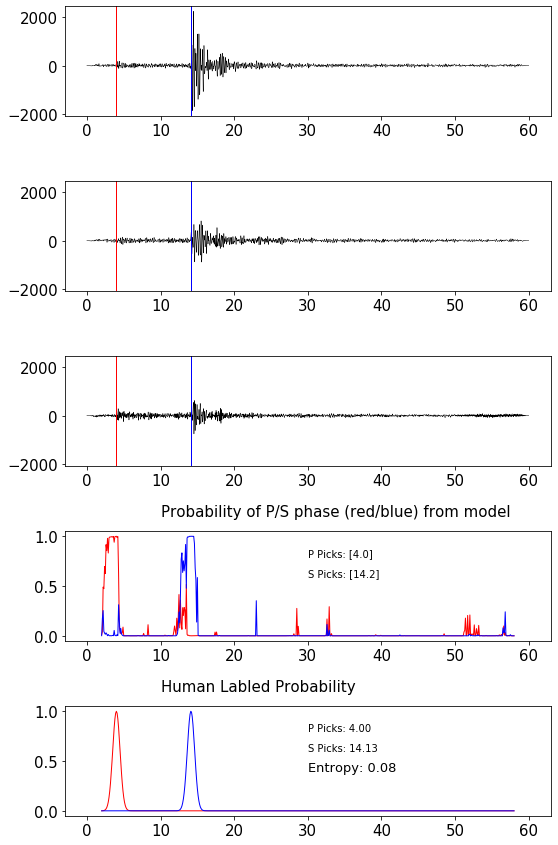

In [14]:
# plot example
number=94
p_picks,s_picks,en=test_model(model,quake,number,True)

## Exercise 1

Finish training the model.

Plot history, confusion matrix, precision-recall curve, and ROC curve.


## Exercise 2

Experiment with different model configurations (number of layers, number of filters, activation functions, number of epochs, etc.). Please use model.summary() function to print the best configuration you used. Plot a figure of accuracy change with parameters used. You can find how much parameters are used with model.summary() function.

